# Gene Expression, Enzyme Kinetics, and Transport

## Gene Expression ODEs

Since all of the genes of interest are constitutively expressed, we can model their rates by the following ODES, where ilvK encodes for transaminase, bCAP encodes for BCAA transport, and BCKDH encodes for the enzyme complex that breaks down BCKAs:

1. $$\frac{d[\text{ilvK}]}{dt} = \gamma_1 - \varsigma_1 \cdot [\text{ilvK}]$$

2. $$\frac{d[\text{bCAP}]}{dt} = \gamma_2 - \varsigma_2 \cdot [\text{bCAP}]$$

3. $$\frac{d[\text{BCKDH}]}{dt} = \gamma_3 - \varsigma_3 \cdot [\text{BCKDH}]$$

$\gamma$ represents the respective basal translation rates, and $\varsigma$ represents the respective breakdown factors.

## Enzyme Kinetics ODEs

The breakdown of all three branched chain amino acids follow a similar pathway:

1. $$\text{Reaction 1}: \text{BCAA}_{in} + \text{oxoglutarate} + \text{ilvK} ^{\xrightarrow[k_{-1}]{k_{1}}}_{\leftarrow} complex ^{\xrightarrow[k_-2]{k_2}}_{1 \leftarrow} \text{BCKA} + \text{ilvK} + \text{glutamate}$$

2. $$\text{Reaction 2}: \text{BCKA} + \text{BCKDH} + NAD^{+} + \text{CoA} ^{\xrightarrow[k_{-3}]{k_{3}}}_{\leftarrow} complex_2 \xrightarrow{k_4} \text{butanol-CoA} + \text{BCKDH} + \text{CO}_2 + \text{NADH}$$

Transaminiation is readily reversible while the the reaction catalyzed by the BCKDH complex is irreversible. We do not concern ourselves with the breakdown of butanol-COA.

Also, we can assume that the concentration of NAD+, oxoglutarate, and CoA are relatively constant as they are replenished by other pathways in the cell.

The enzyme kinetics in isolation look like this:

1. $$\frac{d[BCAA_{in}]}{dt} = -k_1[BCAA][ilvK][oxoglutarate] + k_{-1}[complex_1]$$

2. $$\frac{d[ilvK]}{dt} = -k_1[BCAA][ilvK][oxoglutarate] + k_{-1}[complex_1] + k_2[complex_1]$$

3. $$\frac{d[complex_1]}{dt} = k_1[BCAA][ilvK][oxoglutarate] - k_{-1}[complex_1] - k_2[complex_1] + k_{-2}[BCKA][ilvK][glutamate]$$

4. $$\frac{d[BCKA]}{dt} = k_2[complex_1] - k_{-2}[BCKA][ilvK][glutamate] - k_3[BCKA][BCKDH][NAD+][CoA] + k_{-3}[complex_2]$$

5. $$\frac{d[complex_2]}{dt} = k_3[BCKA][BCKDH][NAD+][CoA] - k_{-3}[complex_2] - k_{4}[complex_2]$$

6. $$\frac{d[BCKDH]}{dt} = -k_3[BCKA][BCKDH][NAD+][CoA] + k_{-3}[complex_2] + k_4[complex_2]$$

7. $$\frac{d[oxoglutarate]}{dt} = \frac{d[NAD+]}{dt} = \frac{d[CoA]}{dt} = 0$$


## Transport

Transport of BCAA in the cell can be characterized as an enzymatic reaction. BCAAs cannot diffuse through the cellular membrane. The symporter encoded by BcaP is a sodium cotransporter.

I have not found a source that explicity says that bCAP is a symporter for NA, but I'll compile some sources soon.

Assumotions: We assume the reverse reaction is impossible since it is likely that the binding sites for BCAAs and NA is on the porition of the symporter outside of the cell. We assume the NA concentration inside and outside the cell is constant due to the activity of NA+/K+ -ATPase; experimental study has also shown that NA+ is not a rate limiting factor.

$$\text{BCAA}_{out} + \text{Na}^{+}_{out} + bCAP ^{\xrightarrow[k_{b_{-1}}]{k_{b_1}}}_{\leftarrow} \text{bCAP}_{complex} \xrightarrow{k_{b_2}} \text{Na}^{+}_{out} + BCAA_{in} + bCAP$$

Then these are the ODEs:

1. $$\frac{d[BCAA_{out}]}{dt} = -k_{b_1}[BCAA_{out}][NA^{+}_{out}][bCAP] + k_{b_{-1}}[bCAP_{complex}]$$
2. $$\frac{d[BCAA_{in}]}{dt} = k_{b_2}[bCAP_{complex}]$$
3. $$\frac{d[NA^+_{in}]}{dt} = \frac{d[NA^+_{out}]}{dt} = 0$$
4. $$\frac{d[bCAP]}{dt} = -k_{b_1}[BCAA_{out}][NA^{+}_{out}][bCAP] + k_{b_{-1}}[BCAP_{complex}] + k_{b_2}[bCAP_{complex}]$$
5. $$\frac{d[bCAP_{complex}]}{dt} = k_{b_1}[BCAA_{out}][NA^{+}_{out}][bCAP] - k_{b_{-1}}[bCAP_{complex}] - k_{b_2}[bCAP_{complex}]$$

## Overall System of ODEs

We arrive at a system of ODEs by combing the rate equations:

1. $$\frac{d[BCAA_{out}]}{dt} = -k_{b_1}[BCAA_{out}][NA^{+}_{out}][bCAP] + k_{b_{-1}}[bCAP_{complex}]$$
2. $$\frac{d[bCAP]}{dt} = -k_{b_1}[BCAA_{out}][NA^{+}_{out}][bCAP] + k_{b_{-1}}[bCAP_{complex}] + k_{b_2}[bCAP_{complex}] + (\gamma_2 - \varsigma_2 \cdot [\text{bCAP}]) $$
3. $$\frac{d[bCAP_{complex}]}{dt} = k_{b_1}[BCAA_{out}][NA^{+}_{out}][bCAP] - k_{b_{-1}}[bCAP_{complex}] - k_{b_2}[bCAP_{complex}]$$

4. $$\frac{d[BCAA_{in}]}{dt} = -k_1[BCAA][ilvK][oxoglutarate] + k_{-1}[complex_1] + k_{b_2}[bCAP_{complex}]$$
5. $$\frac{d[ilvK]}{dt} = -k_1[BCAA][ilvK][oxoglutarate] + k_{-1}[complex_1] + k_2[complex_1] + (\gamma_1 - \varsigma_1 \cdot [\text{ilvK}])$$
6. $$\frac{d[complex_1]}{dt} = k_1[BCAA][ilvK][oxoglutarate] - k_{-1}[complex_1] - k_2[complex_1] + k_{-2}[BCKA][ilvK][glutamate]$$
7. $$\frac{d[BCKA]}{dt} = k_2[complex_1] - k_{-2}[BCKA][ilvK][glutamate] - k_3[BCKA][BCKDH][NAD+][CoA] + k_{-3}[complex_2]$$
8. $$\frac{d[complex_2]}{dt} = k_3[BCKA][BCKDH][NAD+][CoA] - k_{-3}[complex_2] - k_{4}[complex_2]$$
9. $$\frac{d[BCKDH]}{dt} = -k_3[BCKA][BCKDH][NAD+][CoA] + k_{-3}[complex_2] + k_4[complex_2] + (\gamma_3 - \varsigma_3 \cdot [\text{BCKDH}])$$
10. $$\frac{d[NA^+_{in}]}{dt}, \frac{d[NA^+_{out}]}{dt}, \frac{d[oxoglutarate]}{dt}, \frac{d[NAD+]}{dt}, \frac{d[CoA]}{dt} = 0$$

## Modeling Code

In [66]:
import numpy as np #matrix operations
import matplotlib.pyplot as plt #plotter
from scipy.integrate import odeint #ode solver

First we have to count up the species that appear in the ODEs and define initial concentrations in a species dictionary for convenience. We also count up the rate constants.

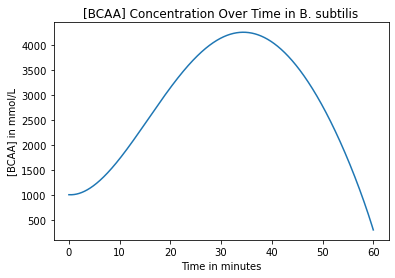

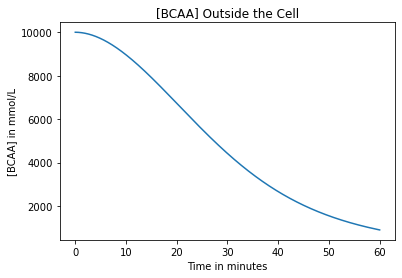

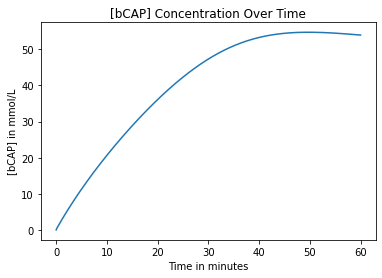

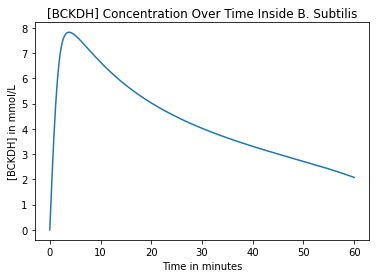

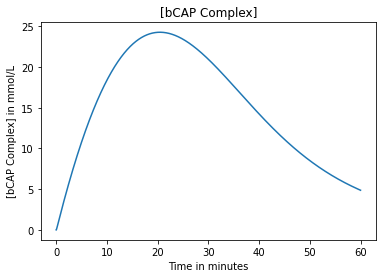

In [67]:
species = { #concentrations in mmol/L
    #transport protein
    'bCAP': 0,
    'bCAP_complex': 0,
    'NA+': 0,
    'BCAA_out': 10000,
    #Enzymes
    'ilvK': 0,
    'BCKDH': 0,
    #Rectants
    'BCAA_in': 1000,
    'oxoglutarate': 1,
    'BCKA': 1,
    'NAD+': 1,
    'CoA': 1,
    'glutamate': 1,
    #Complexes
    'Complex1': 0,
    'Complex2': 0,
}

consts = {
    #Gene expression constants
    'lambda_1': 5,
    'sigma_1': 0.1,
    'lambda_2': 5,
    'sigma_2': 0.1,
    'lambda_3': 5,
    'sigma_3': 0.1, 
    #Transport rate constants
    'k_b1': 0.001,
    'k_b-1': 0.01,
    'k_b2': 10,
    #Rate constants
    'k_1': 10,
    'k_-1': 1,
    'k_2': 1,
    'k_-2': 0.1,
    'k_3': 0.1,
    'k_-3': 0.01,
    'k_4': 1,
    'k_in': 1,
}

#Define initial concs to feed into ODE solver.
s = species
initial_conc = [s['BCAA_out'], s['bCAP'], s['bCAP_complex'], \
    s['BCAA_in'], s['ilvK'], s['Complex1'], 
    s['BCKA'], s['Complex2'], s['BCKDH']]

#Define reaction.
coa_conc = species['CoA']
nadt_conc = species['NAD+']
oxoglutarate_conc = species['oxoglutarate']
na_conc = species['NAD+']
glutamate_conc = species['glutamate']

def reaction(conc, time):
    bcaaout_conc = conc[0]
    bcap_conc = conc[1]
    bcapcomplex_conc = conc[2]
    bcaain_conc = conc[3]
    ilvK_conc = conc[4]
    complex1_conc = conc[5]
    bcka_conc = conc[6]
    complex2_conc = conc[7] 
    bckdh_conc = conc[8]

    dBCAAoutdt = -consts['k_b1']*bcaaout_conc*na_conc*bcap_conc \
        + consts['k_b-1']*bcapcomplex_conc

    dbCAPdt = -consts['k_b1']*bcaaout_conc*na_conc*bcap_conc \
        + consts['k_b-1']*bcapcomplex_conc \
        + consts['k_b2']*bcapcomplex_conc \
        + consts['lambda_2'] - consts['sigma_2']*bcap_conc
    
    dbCAPcomplexdt = consts['k_b1']*bcaaout_conc*na_conc*bcap_conc \
        - consts['k_b-1']*bcapcomplex_conc \
        - consts['k_b2']*bcapcomplex_conc
    
    dBCAAindt = -consts['k_1']*bcaain_conc*ilvK_conc*oxoglutarate_conc \
        + consts['k_-1']*complex1_conc \
        + consts['k_b2']*bcapcomplex_conc 

    dilvKdt = -consts['k_1']*bcaain_conc*ilvK_conc*oxoglutarate_conc \
        + consts['k_-1']*complex1_conc + consts['k_2']*complex1_conc \
        + consts['lambda_1'] - consts['sigma_1']*ilvK_conc
    
    dcomplex1dt = consts['k_1']*bcaain_conc*ilvK_conc*oxoglutarate_conc \
        - consts['k_-1']*complex1_conc -consts['k_2']*complex1_conc \
        + consts['k_-2']*bcka_conc*ilvK_conc*glutamate_conc

    dBCKAdt = consts['k_2']*complex1_conc \
        - consts['k_-2']*bcka_conc*ilvK_conc*glutamate_conc\
        - consts['k_3']*bcka_conc*bckdh_conc*nadt_conc*coa_conc \
        + consts['k_-3']*complex2_conc
    
    dcomplex2dt = consts['k_3']*bcka_conc*bckdh_conc*nadt_conc*coa_conc \
        - consts['k_-3']*complex2_conc - consts['k_4']*complex2_conc
    
    dBCKDHdt = -consts['k_3']*bcka_conc*bckdh_conc*nadt_conc*coa_conc \
        + consts['k_-3']*complex2_conc \
        + consts['k_4']*complex2_conc \
        + consts['lambda_3'] - consts['sigma_3']*bckdh_conc 

    return [dBCAAoutdt, dbCAPdt, dbCAPcomplexdt, 
        dBCAAindt, dilvKdt, dcomplex1dt, \
        dBCKAdt, dcomplex2dt, dBCKDHdt]

#Define timesteps.
t = np.linspace(0, 60, 10000) #step times

solution = odeint(reaction, initial_conc, t)

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 3])
plt.title("[BCAA] Concentration Over Time in B. subtilis")
plt.xlabel('Time in minutes')
plt.ylabel('[BCAA] in mmol/L')
plt.show()

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 0])
plt.title("[BCAA] Outside the Cell")
plt.xlabel('Time in minutes')
plt.ylabel('[BCAA] in mmol/L')
plt.show()

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 1])
plt.title("[bCAP] Concentration Over Time")
plt.xlabel('Time in minutes')
plt.ylabel('[bCAP] in mmol/L')
plt.show()

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 8])
plt.title("[BCKDH] Concentration Over Time Inside B. Subtilis")
plt.xlabel('Time in minutes')
plt.ylabel('[BCKDH] in mmol/L')
plt.show()

fig = plt.figure(0)
fig.clf()
plt.plot(t, solution[:, 2])
plt.title("[bCAP Complex]")
plt.xlabel('Time in minutes')
plt.ylabel('[bCAP Complex] in mmol/L')
plt.show()
    

## Appendix

Below is a diagram of the gene circuit and metabolic pathway for the enzyme kinetics.

![diagram](images/diagram.png)

![pathways](images/pathways.png)

![transport](images/transport.png)